# Data Intake & Cleaning

In [1]:
import sys
import os
import logging
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure src is in path
sys.path.append(os.path.abspath('..'))

from src.cleaning import load_and_clean, run_sanity_checks, generate_universe_audit

# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
DATA_PATH = Path("../databento_data/master_dataset.csv")
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Clening Pipeline
Load the raw data and execute the cleaning pipeline.

In [2]:
if DATA_PATH.exists():
    df = load_and_clean(DATA_PATH)
    print(f"Loaded {len(df):,} rows.")

    # Verify Metadata Enrichment
    print("\nMetadata Sample:")
    cols = ['date', 'root', 'asset_class', 'sleeve', 'region']
    display_cols = [c for c in cols if c in df.columns]
    if display_cols:
        display(df[display_cols].head())
    
    print("\nMetadata Coverage:")
    for col in ['asset_class', 'sleeve', 'region']:
        if col in df.columns:
            print(f"{col}: {df[col].nunique()} unique values, {df[col].isna().sum()} missing")

2025-12-03 19:52:33,512 - INFO - Loading dataset from ../databento_data/master_dataset.csv...
2025-12-03 19:52:33,854 - INFO - Enforcing data types...
2025-12-03 19:52:33,928 - INFO - Sorting data...
2025-12-03 19:52:33,970 - INFO - Removing duplicates...
2025-12-03 19:52:34,102 - INFO - Dropped 3323 duplicate rows.
2025-12-03 19:52:34,103 - INFO - Enriching metadata (parent, asset_class, region)...


Loaded 608,378 rows.


## 2. Data Integrity Checks
Systematic checks for data quality issues.

In [3]:
issues = run_sanity_checks(df)
print("Sanity Check Report:")
for k, v in issues.items():
    print(f"  {k}: {v}")

2025-12-03 19:52:39,183 - INFO - Running sanity checks...
2025-12-03 19:52:39,314 - WARNING - Found 1 rows with negative prices.


Sanity Check Report:
  na_counts: {'date': 0, 'raw_symbol': 0, 'expiration': 0, 'open': 0, 'high': 0, 'low': 0, 'close': 0, 'volume': 0, 'currency': 0, 'instrument_id': 0, 'root': 0, 'month_code': 0, 'year_code': 0, 'parent': 0, 'asset_class': 0, 'region': 0}
  bad_ohlc_rows: 0
  neg_price_rows: 1
  neg_price_roots: {'CL.FUT': 1}
  nonpos_vol_rows: 0


In [4]:
audit = generate_universe_audit(df)
display(audit.head())

2025-12-03 19:52:41,496 - INFO - Generating universe audit...


,first_date,last_date,n_days,avg_daily_contracts,avg_volume
parent,,,,,
6A.FUT,2015-01-01,2024-12-31,3111,110,18134.996996
6B.FUT,2015-01-01,2024-12-31,3111,108,19688.243598
6C.FUT,2015-01-01,2024-12-31,3111,109,12040.753233
6E.FUT,2015-01-01,2024-12-31,3111,113,28155.846340
6J.FUT,2015-01-01,2024-12-31,3111,110,25292.755893


### 3.1 Coverage 
Visualizing the start and end dates for each asset class.

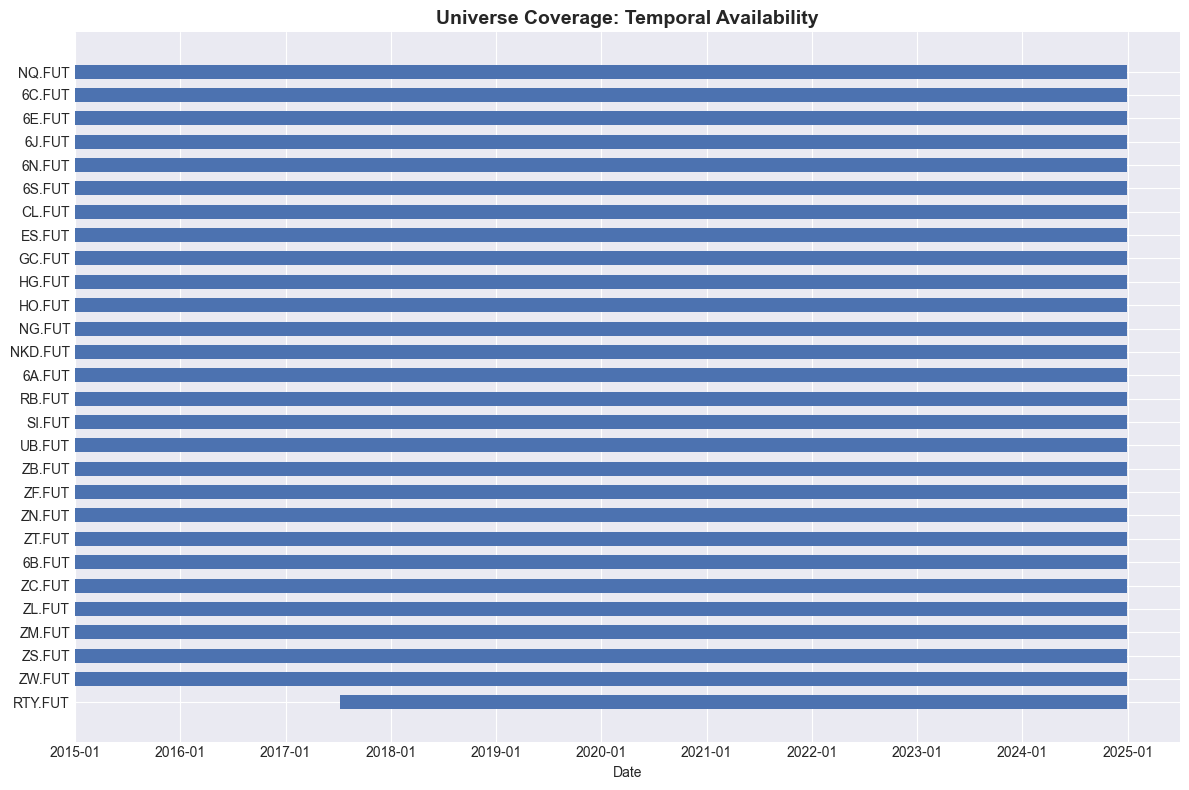

In [5]:
def plot_coverage(audit_df):
    if audit_df.empty:
        print("No data to plot.")
        return

    try:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Sort by start date
        audit_df = audit_df.sort_values('first_date', ascending=False)
        
        y_pos = range(len(audit_df))
        
        # Calculate duration
        duration = audit_df['last_date'] - audit_df['first_date']
        
        # Convert dates to matplotlib numbers for barh
        # Explicit cast to ensure compatibility
        start_dates = mdates.date2num(audit_df['first_date'].astype('datetime64[ns]'))
        
        ax.barh(y_pos, duration.dt.days, left=start_dates, height=0.6, color='#4c72b0')
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(audit_df.index)
        ax.xaxis_date() # Interpret x-axis as dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        
        ax.set_title('Universe Coverage: Temporal Availability', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not render chart: {e}")

plot_coverage(audit)

### 3.2 Liquidity Profile
Average daily volume by root.

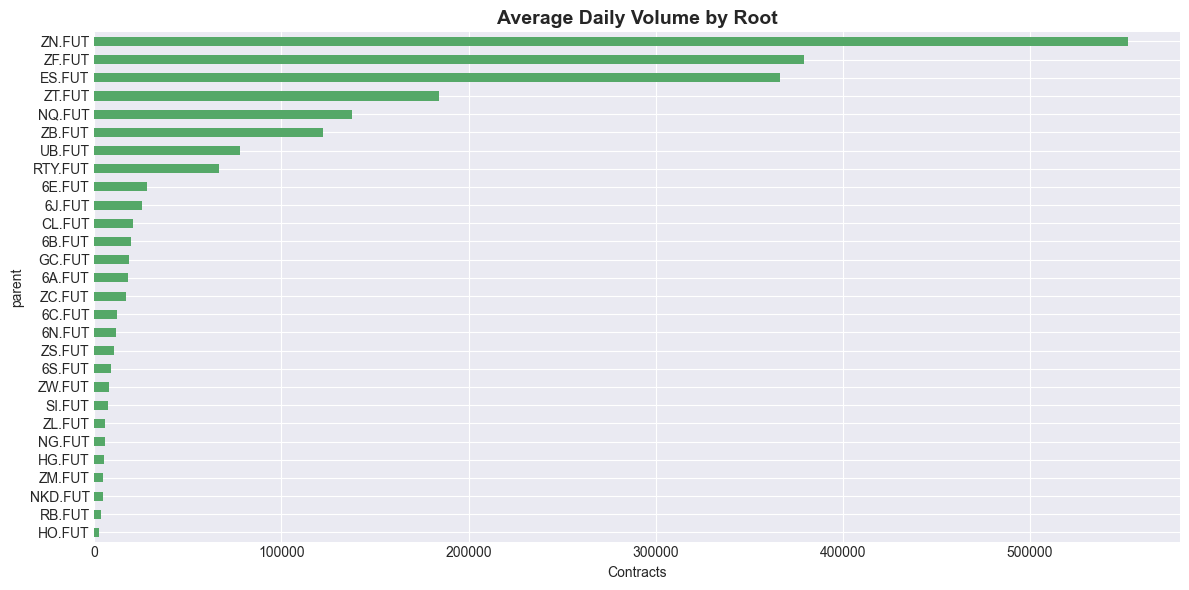

In [6]:
def plot_liquidity(audit_df):
    if 'avg_volume' not in audit_df.columns or audit_df.empty:
        return
        
    fig, ax = plt.subplots(figsize=(12, 6))
    audit_df.sort_values('avg_volume', ascending=True)['avg_volume'].plot(kind='barh', ax=ax, color='#55a868')
    
    ax.set_title('Average Daily Volume by Root', fontsize=14, fontweight='bold')
    ax.set_xlabel('Contracts')
    plt.tight_layout()
    plt.show()

plot_liquidity(audit)

In [7]:
# Configuration
OUTPUT_DIR = Path("../data/processed")
OUTPUT_FILE = OUTPUT_DIR / "master_dataset_cleaned.parquet"

# Create directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Save to Parquet
if 'df' in locals() and not df.empty:
    try:
        df.to_parquet(OUTPUT_FILE, index=False)
        print(f"Successfully saved {len(df):,} rows to {OUTPUT_FILE}")
    except Exception as e:
        print(f"Error saving data: {e}")
else:
    print("DataFrame 'df' is missing or empty. Skipping save.")

Successfully saved 608,378 rows to ../data/processed/master_dataset_cleaned.parquet
